# 3.0 Pose Spatial Classifier

`PoseSpatialClassifier` class is designed to classify poses based on the added pose dimensions.

### Setup and Modules

In [1]:
import re
import pandas as pd

### Implementation

1. `get_face_position()`:  Determines if the face is oriented towards the `front` or `back` based on the z-axis value of the head..
2. `get_body_position()`: Classifies body position as `inverted`, `upright`, or `horizontal` by comparing the vertical alignment of head, chest, stomach, and hips.
3. `get_legs_position()`: Classifies legs position by scoring differences in mid-hip-to-knees, shoulder-to-knees, and hips-to-feet angles against reference legs positions.
4. `get_grip_position()`: Classifies grip position by scoring differences in shoulder-to-wrist, elbow-to-knuckles, and thumb-to-knuckles angles against reference grip positions.
5. `get_body_position_undefined()`, `get_legs_position_undefined()`, `get_grip_position_undefined()`: These functions handle cases where standard position classification criteria are not met, using a more tolerant approach to find the closest reference match or returning 'unknown' if no close match is found.

In [6]:
import re
import pandas as pd

class PoseSpatialClassifier:
    def __init__(self, data, ref_body, ref_legs, ref_grip):
        self.data = data
        self.ref_body = ref_body
        self.ref_legs = ref_legs
        self.ref_grip = ref_grip

        self.body_match_count = 0
        self.body_undefined_count = 0

        self.legs_match_count = 0
        self.legs_undefined_count = 0

        self.grip_match_count = 0
        self.grip_undefined_count = 0

        self.data['pos_face'] = self.data.apply(self.get_face_position, axis=1)
        self.data['pos_body'] = self.data.apply(self.get_body_position, axis=1)
        self.data['pos_legs'] = self.data.apply(self.get_legs_position, axis=1)
        self.data['pos_grip'] = self.data.apply(self.get_grip_position, axis=1)

    def get_face_position(self, row):
        return "front" if row["head_z"] < 0 else "back"

    def get_body_position(self, row):
        self.body_match_count += 1
        if row['head_y'] > row['chest_y'] > row['stomach_y'] > row['hip_y']:
            return "inversion"
        elif row['head_y'] < row['chest_y'] < row['stomach_y'] < row['hip_y'] and abs(row['head_x'] - row['hip_x']) < 0.2:
            return "upright"
        elif row['head_y'] < row['hip_y'] and abs(row['head_y'] - row['hip_y']) < 0.2:
            return "horizontal"
        else:
            result = self.get_body_position_undefined(row)
            return result        

    def get_body_position_undefined(self, row):
        self.body_undefined_count += 1
        a_cols = ['a_head_to_stomach', 'a_chest_to_hip']
        
        scores = {}
        for _, ref_row in self.ref_body.iterrows():
            score = sum(abs(row[col] - ref_row[col]) for col in a_cols)
            scores[ref_row['pose_name']] = score
    
        closest_match_spec = min(scores, key=scores.get)
        closest_score = scores[closest_match_spec]
    
        if closest_score > 180:
            return 'unknown'
        else:
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', closest_match_spec)
            return closest_match
    
    def get_legs_position(self, row):
        l_cols = ['landmark_24_x', 'landmark_24_y', 'landmark_26_x', 'landmark_26_y', 'landmark_28_x', 'landmark_28_y',
                  'landmark_23_x', 'landmark_23_y', 'landmark_25_x', 'landmark_26_y', 'landmark_27_x', 'landmark_27_y',]
        a_cols = ['a_mid_hip_to_knees', 'a_rgt_hip_to_foot', 'a_rgt_foot_to_ankle', 'a_lft_hip_to_foot', 'a_lft_foot_to_ankle']
        d_cols = ['dist_head_to_rgt_ankle','dist_head_to_lft_ankle', 'dist_bet_wrists','dist_bet_knees','dist_bet_ankles']
        
        scores = {}
        for _, ref_row in self.ref_legs.iterrows():
            l_score = sum(1 for col in l_cols if abs(row[col] - ref_row[col]) < 0.25)
            a_score = sum(1 for col in a_cols if abs(row[col] - ref_row[col]) < 35)
            d_score = sum(1 for col in d_cols if abs(row[col] - ref_row[col]) < 0.25)
            total_score = l_score + a_score + d_score
            scores[ref_row['pose_name']] = total_score

        max_score_pose = max(scores, key=scores.get)
        max_score = scores[max_score_pose]

        if max_score < 15:
            return 'None'
        else:
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', max_score_pose)
            return closest_match
        
    def get_legs_position_undefined(self, row):
        self.legs_undefined_count += 1
        columns = self.data.columns
        l_cols = [col for col in columns if col.endswith('_x') or col.endswith('_y')]
        
        scores = {}
        for _, ref_row in self.ref_legs.iterrows():
            l_score = sum(1 for col in l_cols if abs(row[col] - ref_row[col]) < 0.2)
            total_score = l_score
            scores[ref_row['pose_name']] = total_score

        max_score_pose = max(scores, key=scores.get)
        max_score = scores[max_score_pose]

        if max_score < 5:
            return 'None'
        else:
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', max_score_pose)
            return closest_match
            
    def get_grip_position(self, row):
        l_cols = ['landmark_12_x', 'landmark_12_y', 'landmark_14_x', 'landmark_14_y', 'landmark_16_x', 'landmark_16_y',
                  'landmark_11_x', 'landmark_11_y', 'landmark_13_x', 'landmark_13_y', 'landmark_15_x', 'landmark_15_y',]
        d_cols = ['dist_rgt_shoulder_to_wrist','dist_lft_shoulder_to_wrist','dist_bet_wrists','dist_bet_elbows','dist_rgt_elbow_to_hip','dist_lft_elbow_to_hip']
        a_cols = ['a_rgt_shoulder_to_wrist', 'a_rgt_elbow_to_knuckles','a_lft_shoulder_to_wrist', 'a_lft_elbow_to_knuckles',]
        
        scores = {}
        for _, ref_row in self.ref_grip.iterrows():
            l_score = sum(1 for col in l_cols if abs(row[col] - ref_row[col]) < 0.25)
            a_score = sum(1 for col in a_cols if abs(row[col] - ref_row[col]) < 35)
            d_score = sum(1 for col in d_cols if abs(row[col] - ref_row[col]) < 0.25)
            total_score = l_score + a_score + d_score
            scores[ref_row['pose_name']] = total_score

        max_score_pose = max(scores, key=scores.get)
        max_score = scores[max_score_pose]

        if max_score < 15:
            return 'None'
        else:
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', max_score_pose)
            return closest_match

    def get_grip_position_undefined(self, row):
        self.grip_undefined_count += 1
        columns = self.data.columns
        l_cols = [col for col in columns if col.endswith('_x') or col.endswith('_y')]
        
        scores = {}
        for _, ref_row in self.ref_grip.iterrows():
            l_score = sum(1 for col in l_cols if abs(row[col] - ref_row[col]) < 0.2)
            total_score = l_score
            scores[ref_row['pose_name']] = total_score

        max_score_pose = max(scores, key=scores.get)
        max_score = scores[max_score_pose]

        if max_score < 5:
            return 'None'
        else:
            suffixes_to_remove = r'(-rgt|-lft|-inv|-rgt-inv|-lft-inv|-center|)$'
            closest_match = re.sub(suffixes_to_remove, '', max_score_pose)
            return closest_match
            
    def save_transformed_data(self, filename):
        self.data.to_csv(filename, index=False)

# Usage

## Static Images

In [8]:
tricks = pd.read_csv('data/internal/tricks/pose_data.csv')

ref_body = pd.read_csv('data/internal/positions/body/pose_data.csv')
ref_legs = pd.read_csv('data/internal/positions/legs/pose_data.csv')
ref_grip = pd.read_csv('data/internal/positions/grip/pose_data.csv')

results = PoseSpatialClassifier(tricks, ref_body, ref_legs, ref_grip)
results.save_transformed_data('data/internal/tricks/pose_data_classified.csv')

print("Body Position Classification Score:", results.body_match_count, results.body_undefined_count)
print("Legs Position Classification Score:", results.legs_match_count, results.legs_undefined_count)
print("Grip Position Classification Score:", results.grip_match_count, results.grip_undefined_count)

results.data[['image_filename','pose_name','pos_face','pos_body','pos_legs','pos_grip']]

Body Position Classification Score: 554 79
Legs Position Classification Score: 0 0
Grip Position Classification Score: 0 0


,image_filename,pose_name,pos_face,pos_body,pos_legs,pos_grip
0,advanced-figurehead-lft.png,advanced-figurehead-lft,front,upright,demi-plie-releve,two-hand-basic-cup
1,advanced-figurehead-rgt.png,advanced-figurehead-rgt,back,upright,demi-plie-releve,two-hand-basic-cup
2,aerial-leg-hold-crucifix-lft.png,aerial-leg-hold-crucifix-lft,front,upright,pencil,one-hand-basic-grip
3,aerial-leg-hold-crucifix-rgt.png,aerial-leg-hold-crucifix-rgt,front,upright,pencil,one-hand-basic-grip
4,air-walk-lft.png,air-walk-lft,front,upright,pencil,two-hand-full-bracket-split-grip
...,...,...,...,...,...,...
549,wrist-sit-rgt.png,wrist-sit-rgt,front,upright,straddle,two-hand-crossed-grip
550,yogini-lft.png,yogini-lft,back,upright,tuck,underarm-grip
551,yogini-rgt.png,yogini-rgt,back,upright,rolled-toes-releve,underarm-grip
552,yogini-twisted-lft.png,yogini-twisted-lft,front,upright,step-around,underarm-grip


In [71]:
dance_data = pd.read_csv('data/ground_truth/processed/upright/pose_data2.csv')

ref_body = pd.read_csv('data/internal/positions/body/pose_data2.csv')
ref_legs = pd.read_csv('data/internal/positions/legs/pose_data2.csv')
ref_grip = pd.read_csv('data/internal/positions/grip/pose_data2.csv')

results = PoseSpatialClassifier(dance_data, ref_body, ref_legs, ref_grip)
#results.save_transformed_data('data/ground_truth/processed/combined/pose_data.csv')

print("Body Position Classification Score:", results.body_match_count, results.body_undefined_count)
print("Legs Position Classification Score:", results.legs_match_count, results.legs_undefined_count)
print("Grip Position Classification Score:", results.grip_match_count, results.grip_undefined_count)

results.data[['image_filename','secs','pos_face','pos_body','pos_legs','pos_grip']]

Body Position Classification Score: 38 0
Legs Position Classification Score: 38 0
Grip Position Classification Score: 38 0


,image_filename,secs,pos_face,pos_body,pos_legs,pos_grip
0,0000_00000000.png,0,front,upright,passe,one-hand-strong-hold
1,0000_00000011.png,0,back,upright,plie-releve-first-position,one-hand-strong-hold
2,0000_00000022.png,0,back,upright,grand-battement-backward,two-hand-iguana-grip
3,0000_00000033.png,0,back,upright,pole-walk,one-hand-basic-grip
4,0000_00000044.png,0,back,upright,stag,two-hand-embrace-grip
5,0000_00000055.png,0,back,upright,plie-releve,two-hand-reverse-grab
6,0001_00000066.png,1,back,upright,releve,baseball-grip
7,0001_00000077.png,1,back,upright,pencil,baseball-grip
8,0001_00000088.png,1,front,upright,port-de-bras-tip-toes,baseball-grip
9,0001_00000099.png,1,front,upright,port-de-bras,two-hand-embrace-grip


In [43]:
from helpers.data_visualization_utils import *

def visualize_pose_dimension_by_keyword(source_image_dir, input_data, category, keyword):
    filtered_data = input_data[input_data[category].str.contains(keyword, na=False)]
    print(f"{len(filtered_data)} items found.")
    for i, row in filtered_data.iterrows():
        focus_landmarks = {
            'Head': (row['head_x'], row['head_y']),
            'R.Wrist': (row['landmark_16_x'], row['landmark_16_y']),
            'L.Wrist': (row['landmark_15_x'], row['landmark_15_y']),
            
            'R.Armpit': (row['landmark_12_x'], row['landmark_12_y']),
            'L.Armpit': (row['landmark_11_x'], row['landmark_11_y']),
            'R.Hip': (row['landmark_24_x'], row['landmark_24_y']),
            'L.Hip': (row['landmark_23_x'], row['landmark_23_y']),
            'R.Knee': (row['landmark_26_x'], row['landmark_26_y']),
            'L.Knee': (row['landmark_25_x'], row['landmark_25_y']),
            'R.Ankle': (row['landmark_28_x'], row['landmark_28_y']),
            'L.Ankle': (row['landmark_27_x'], row['landmark_27_y']),
        }
        
        focus_angles = {
            'Head->Stomach': (row['a_head_to_stomach'], row['head_x'], row['head_y'],row['chest_x'], row['chest_y'], row['stomach_x'], row['stomach_y']),
            'Chest->M.Hip': (row['a_chest_to_hip'], row['chest_x'], row['chest_y'],row['stomach_x'], row['stomach_y'], row['hip_x'], row['hip_y']),
            'M.Hip->Knees': (row['a_mid_hip_to_knees'], row['landmark_26_x'], row['landmark_26_y'],row['hip_x'], row['hip_y'], row['landmark_27_x'], row['landmark_27_y']),
    
        }
    
        focus_heights = {
            'Spine': (row['hgt_spine'], row['head_x'],row['head_y'],row['hip_x'],row['hip_y']),
            'R.Leg': (row['hgt_rgt_leg'], row['landmark_24_x'],row['landmark_24_y'],row['landmark_32_x'],row['landmark_32_y']),
            'L.Leg': (row['hgt_lft_leg'], row['landmark_23_x'],row['landmark_23_y'],row['landmark_31_x'],row['landmark_31_y']),
            'R.Arm': (row['wid_rgt_arm'], row['landmark_12_x'],row['landmark_12_y'],row['knuckles_right_x'],row['knuckles_right_y']),
            'L.Arm': (row['wid_lft_arm'], row['landmark_11_x'],row['landmark_11_y'],row['knuckles_left_x'],row['knuckles_left_y']),
        }   
        visualize_pose_coordinates(source_image_dir, row, focus_landmarks)
        #visualize_pose_dimension_lengths(source_image_dir, row, focus_heights)
        #visualize_pose_dimension_angles(source_image_dir, row, focus_angles)

36 items found.


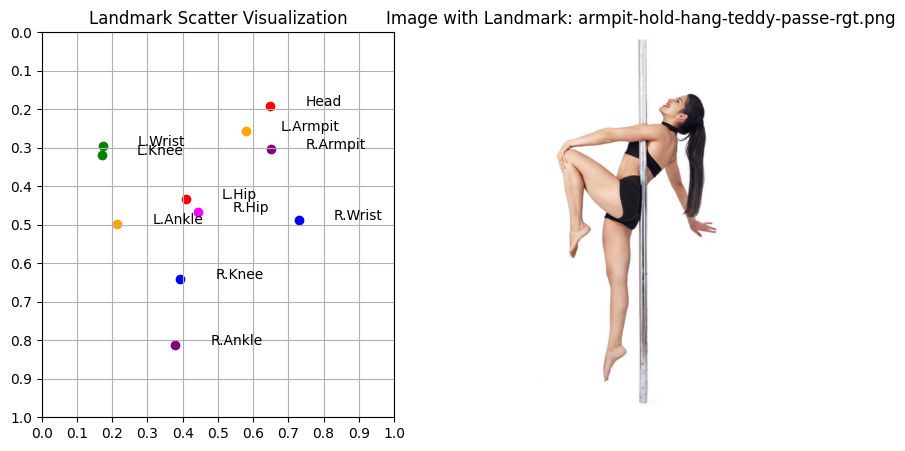

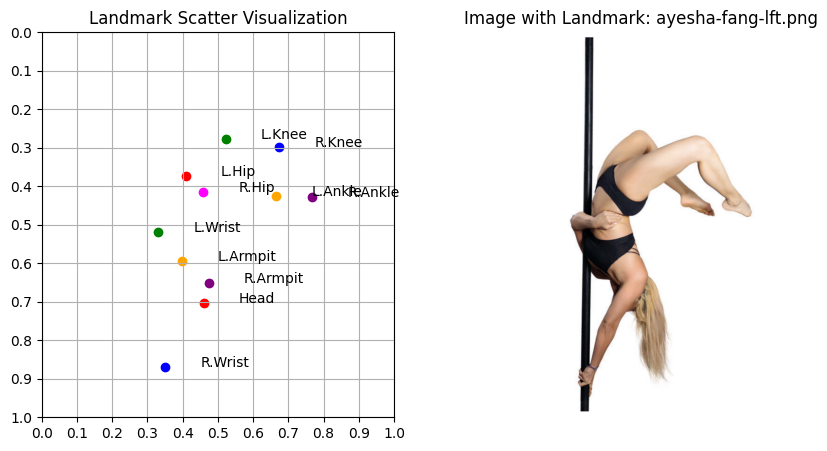

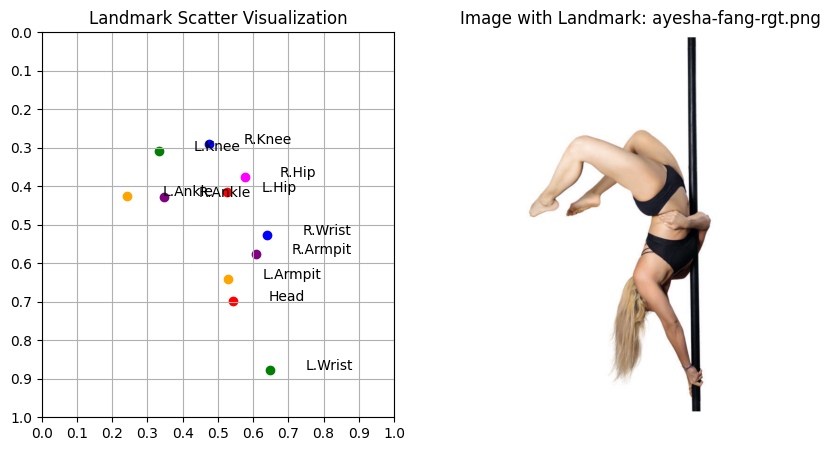

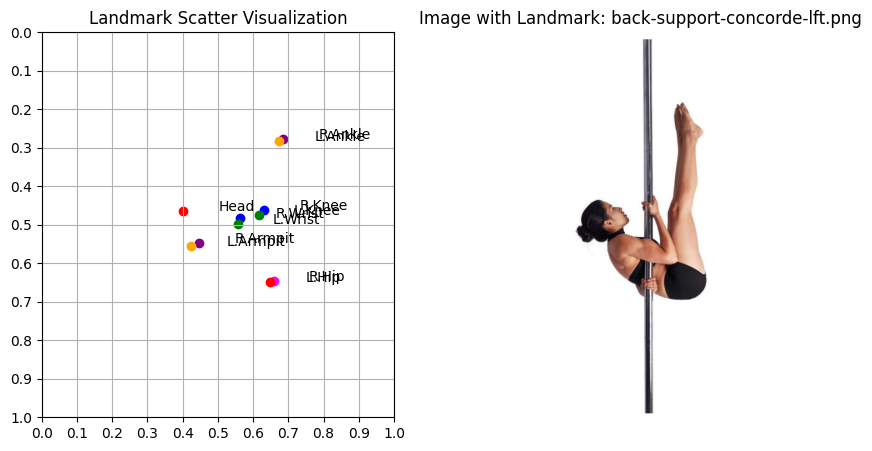

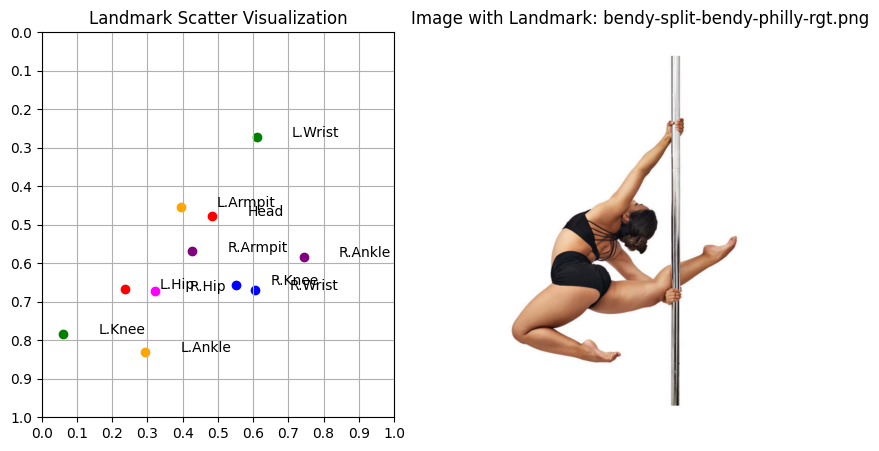

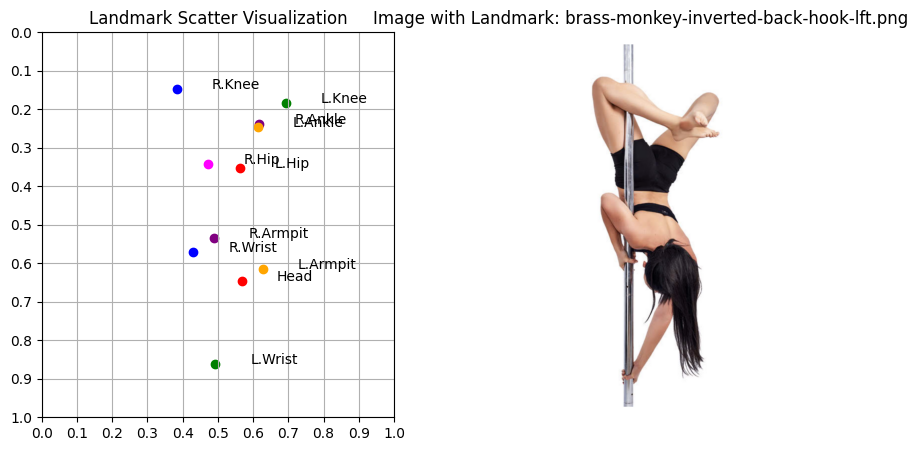

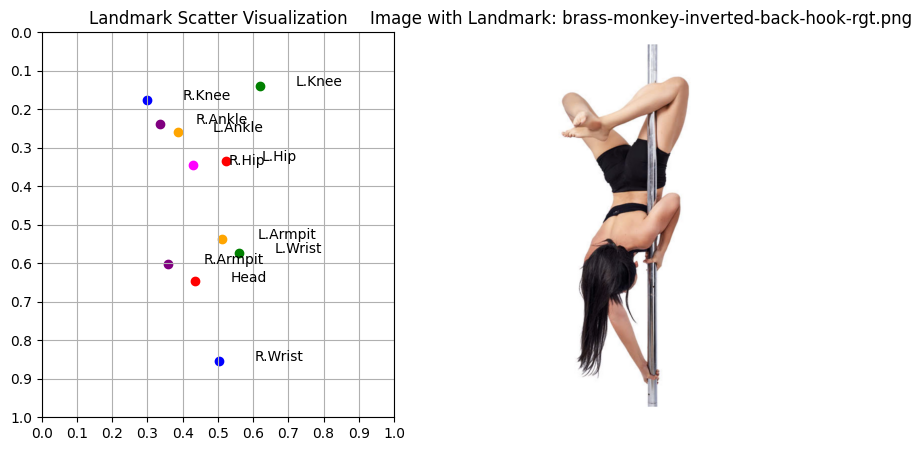

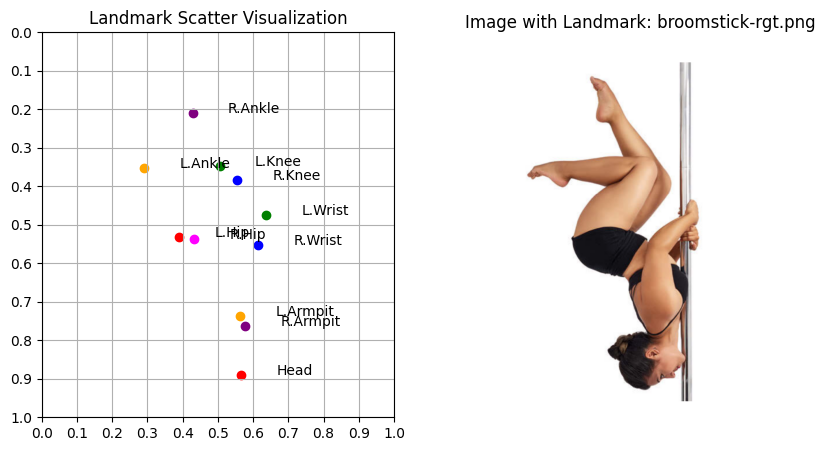

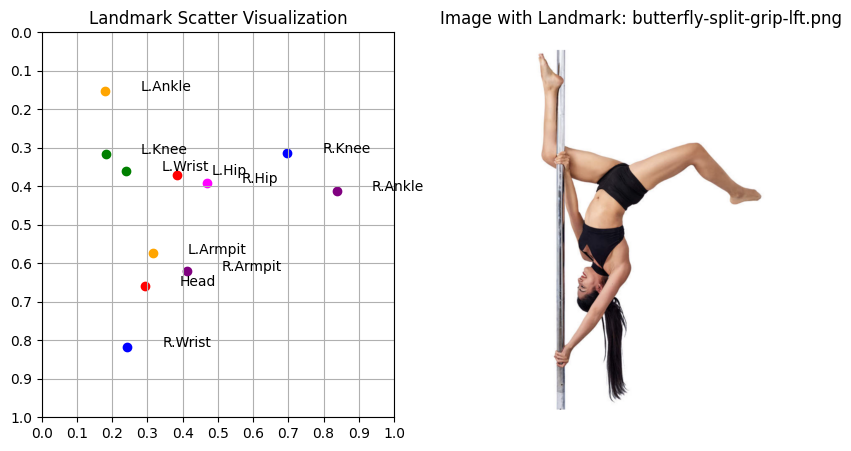

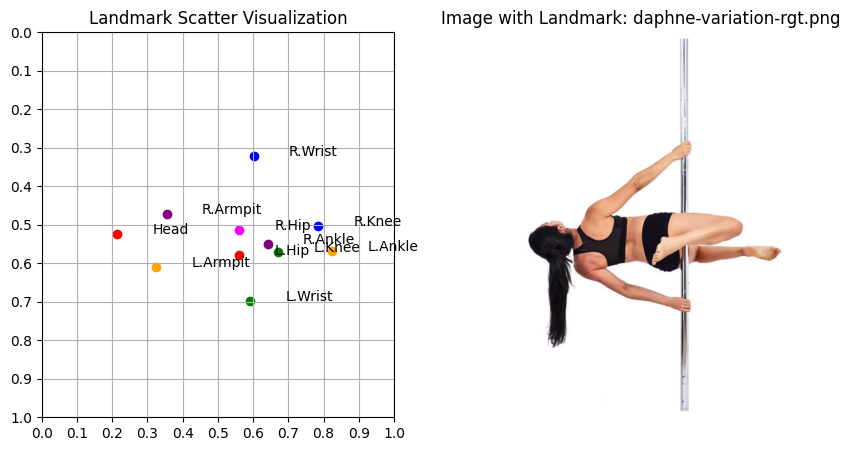

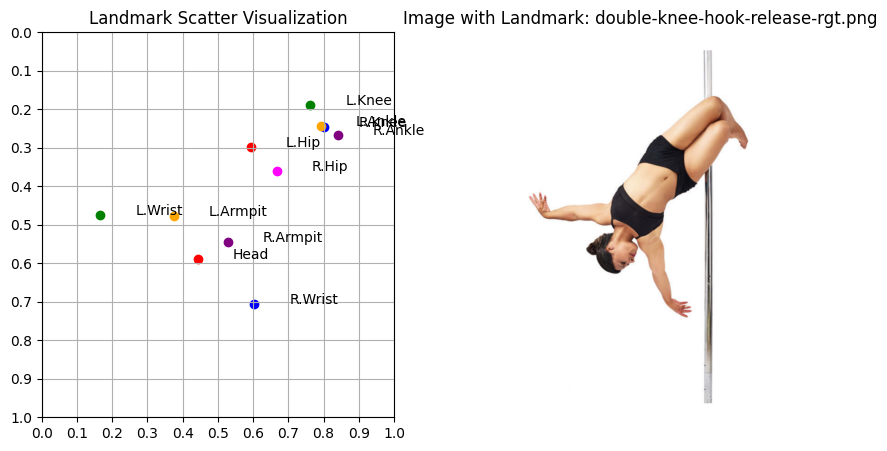

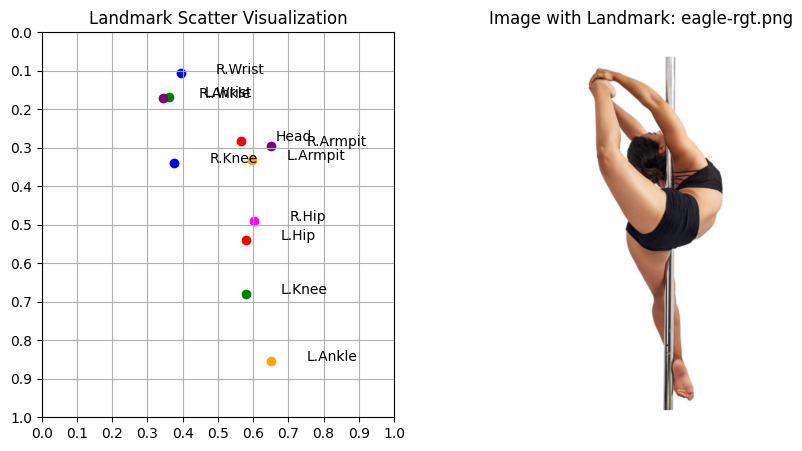

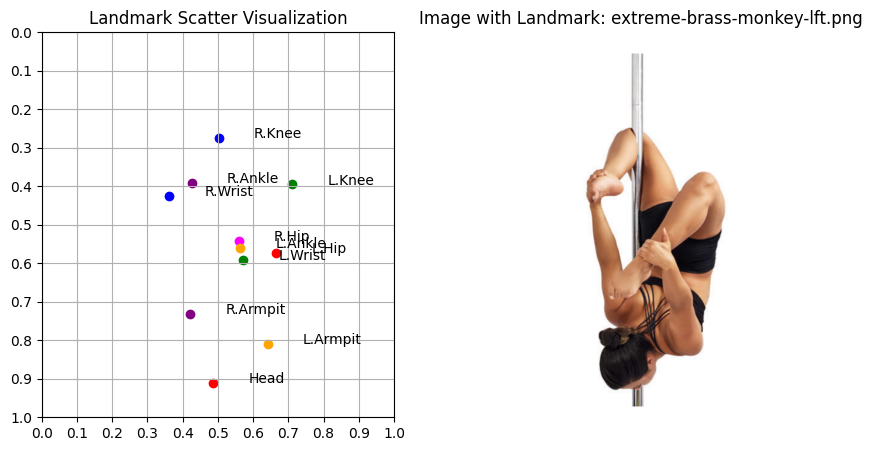

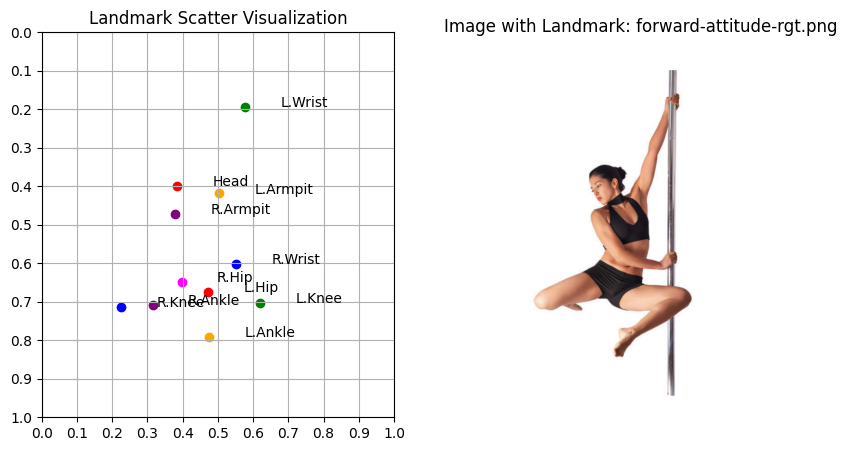

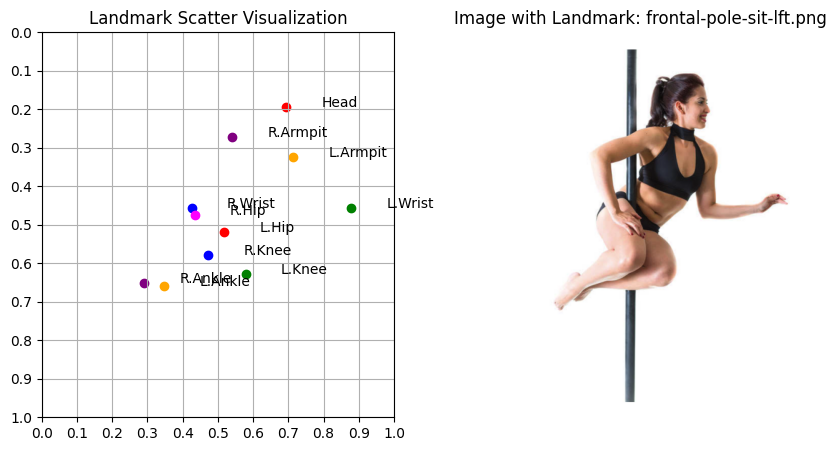

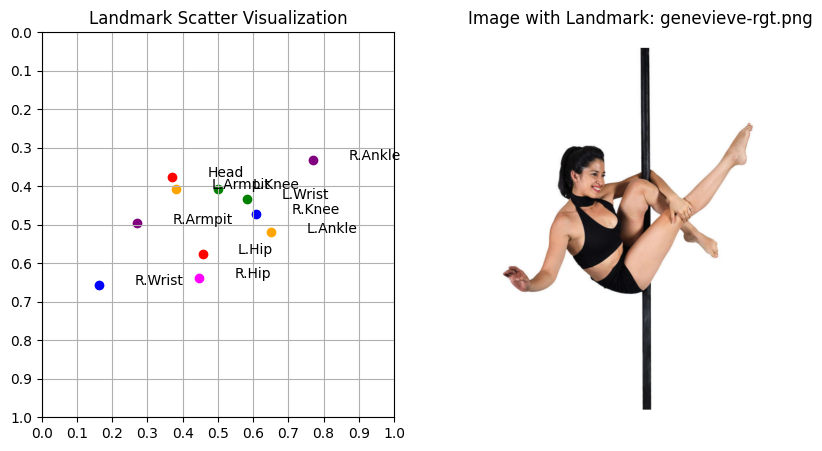

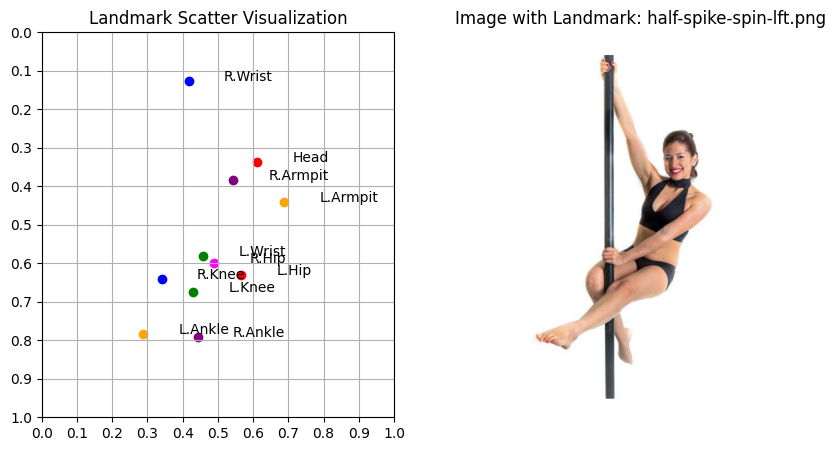

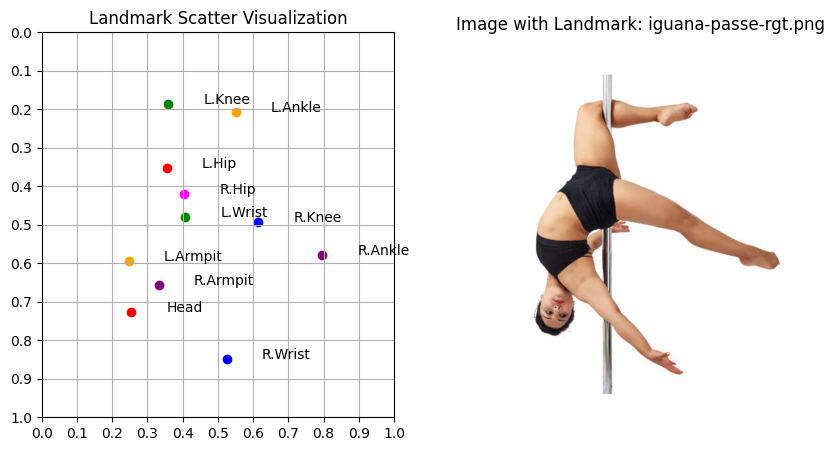

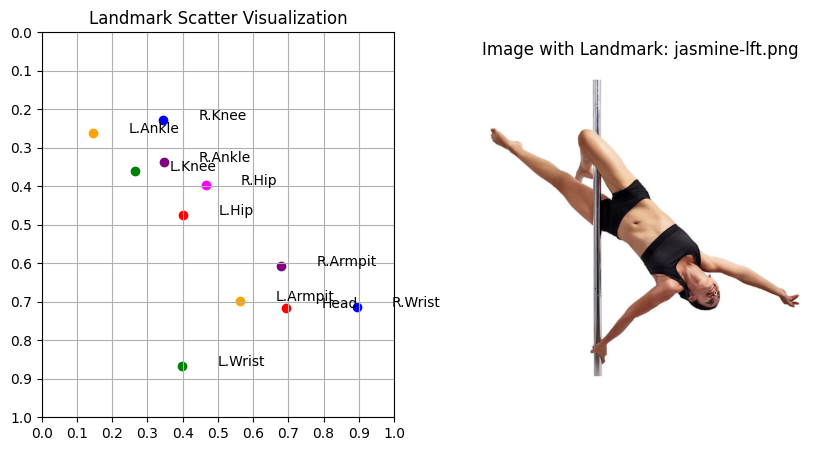

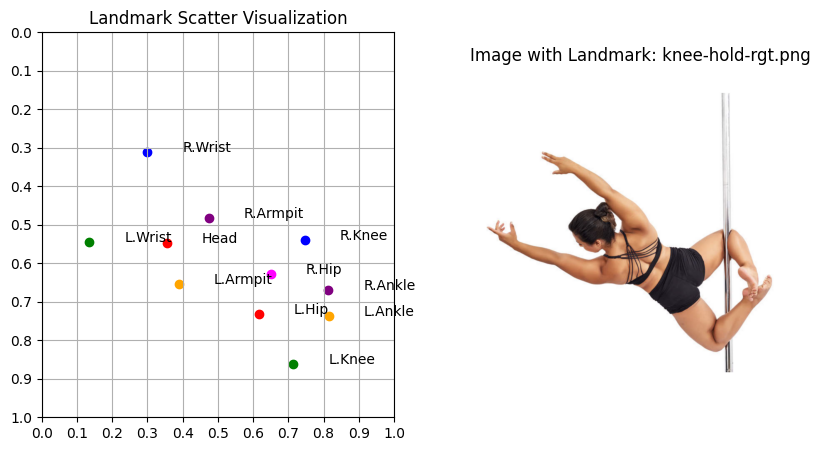

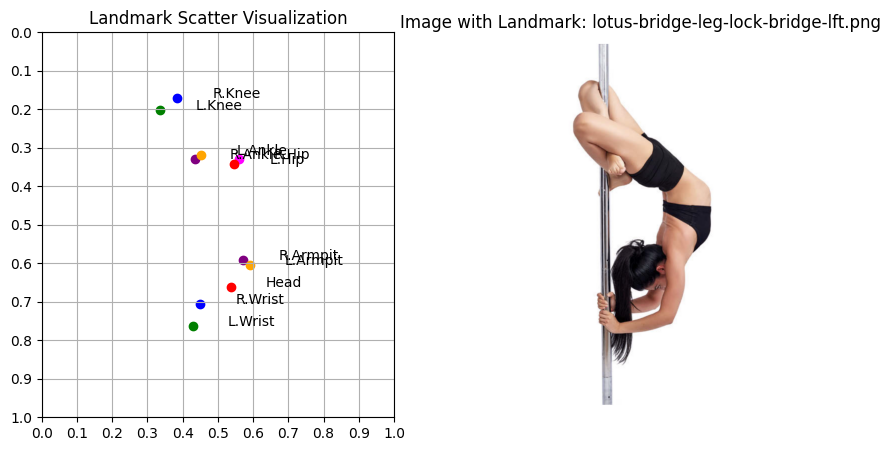

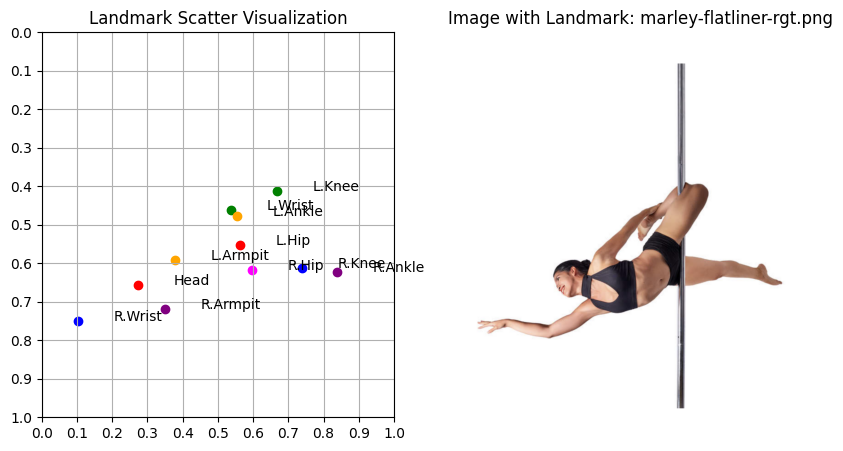

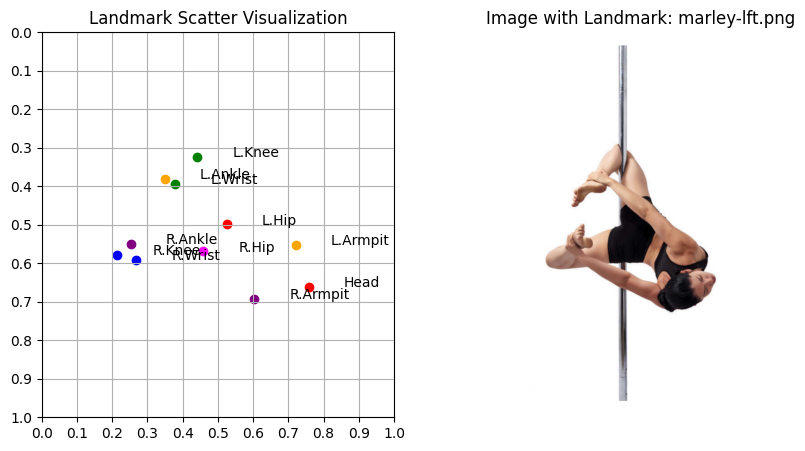

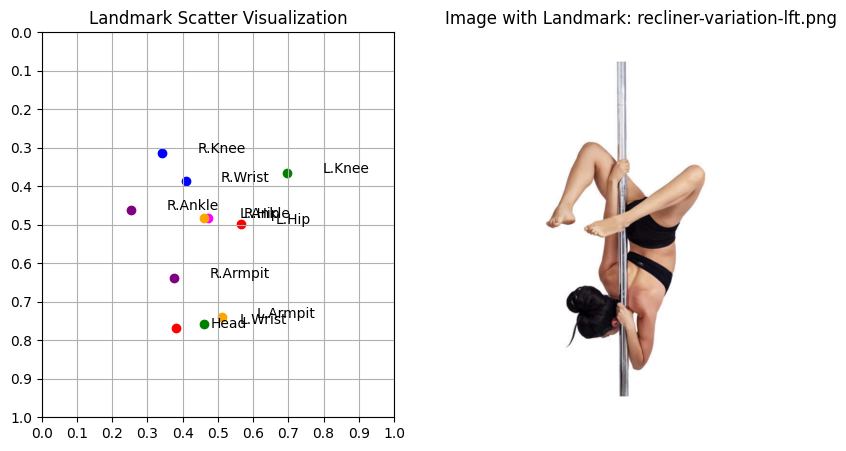

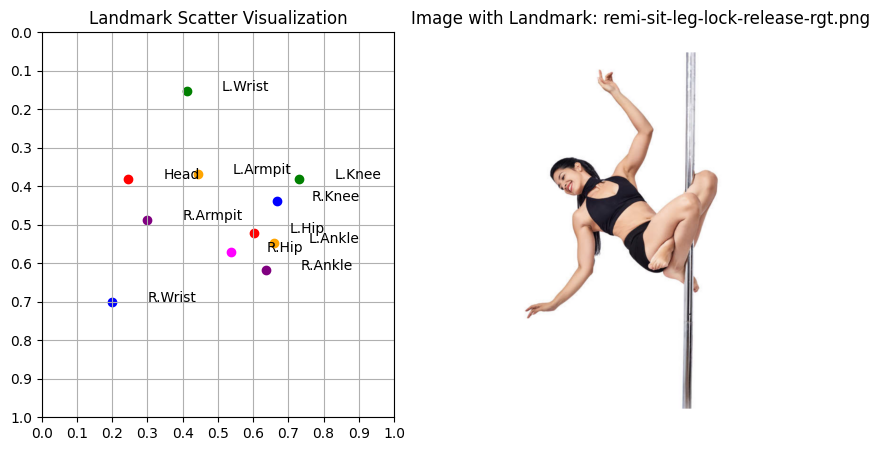

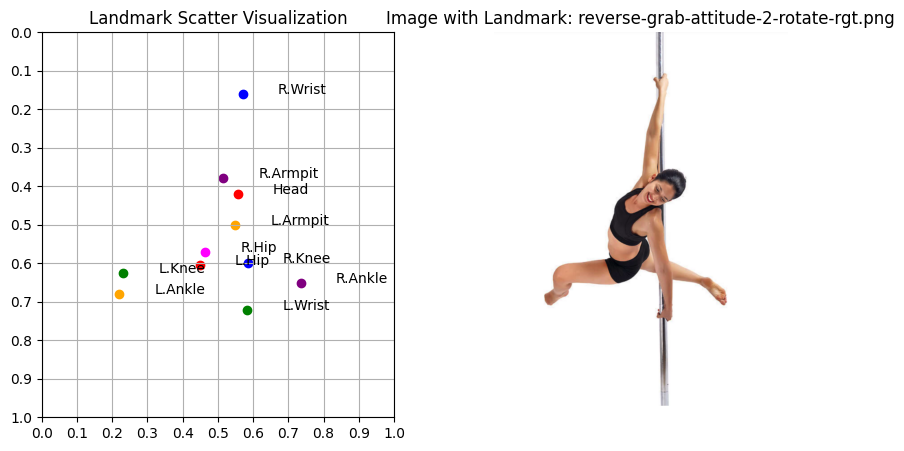

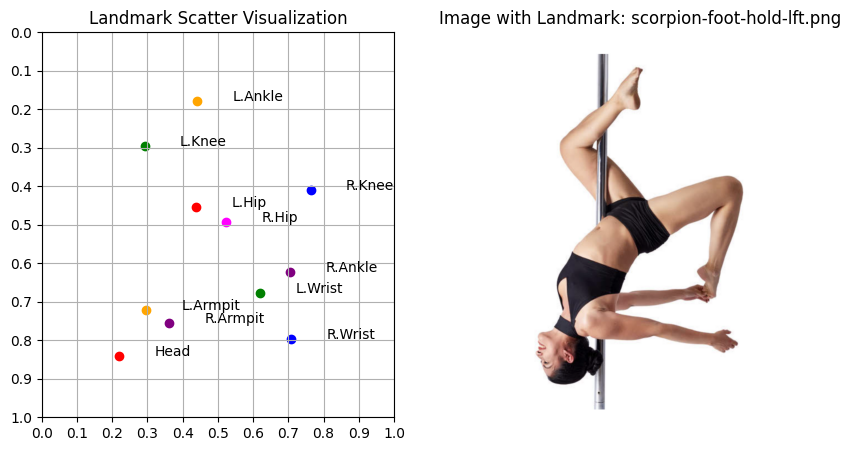

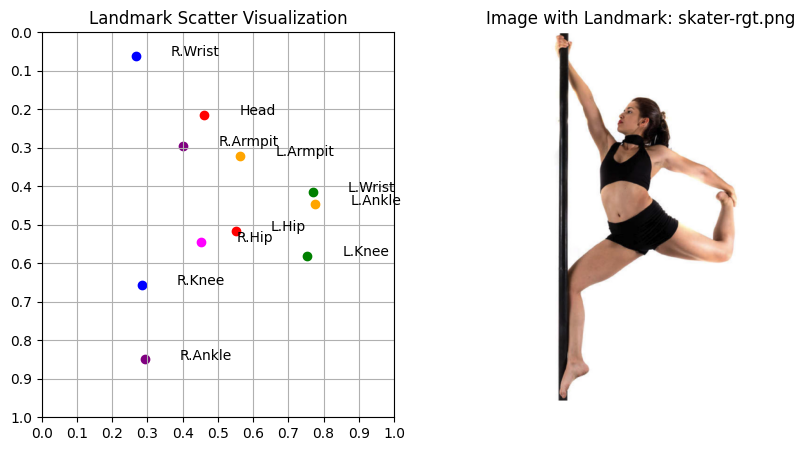

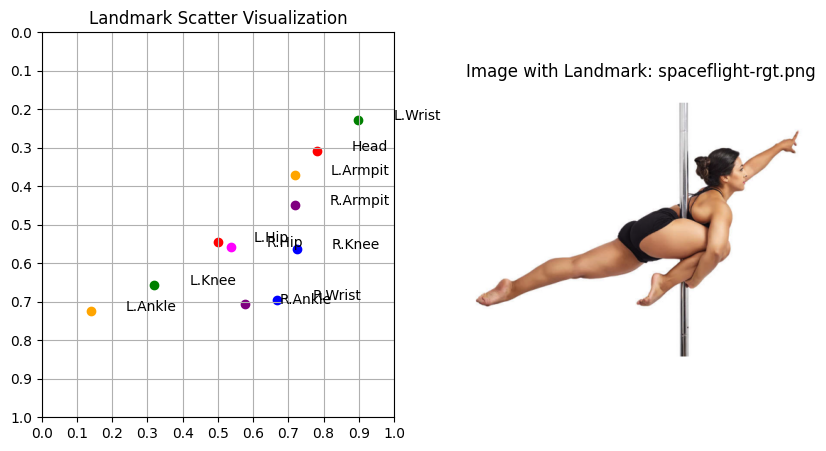

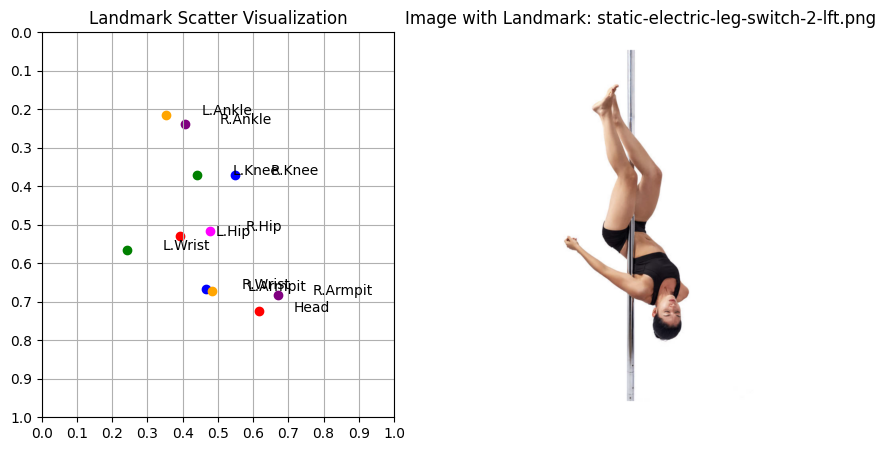

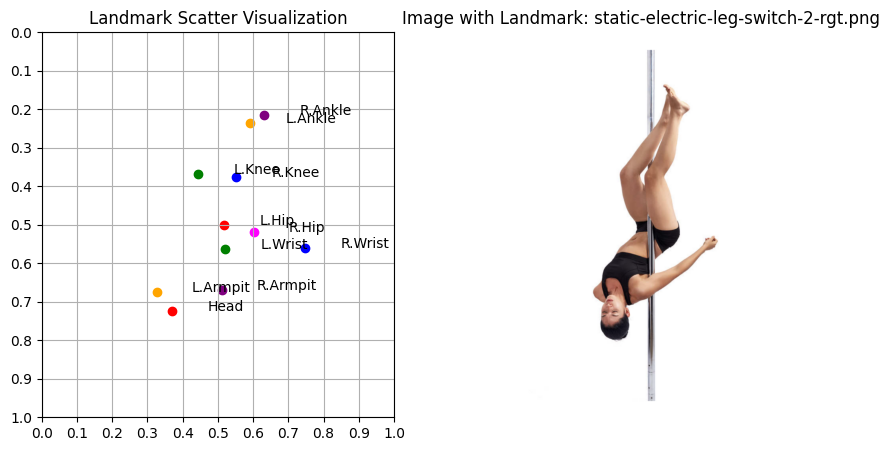

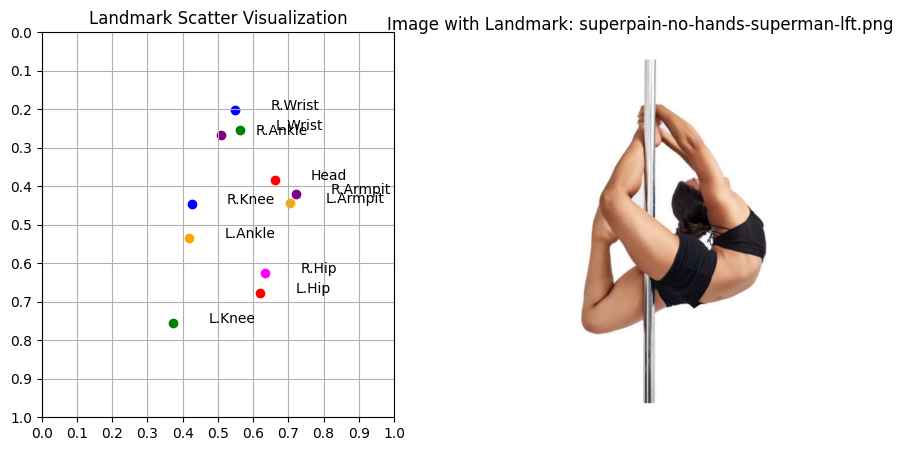

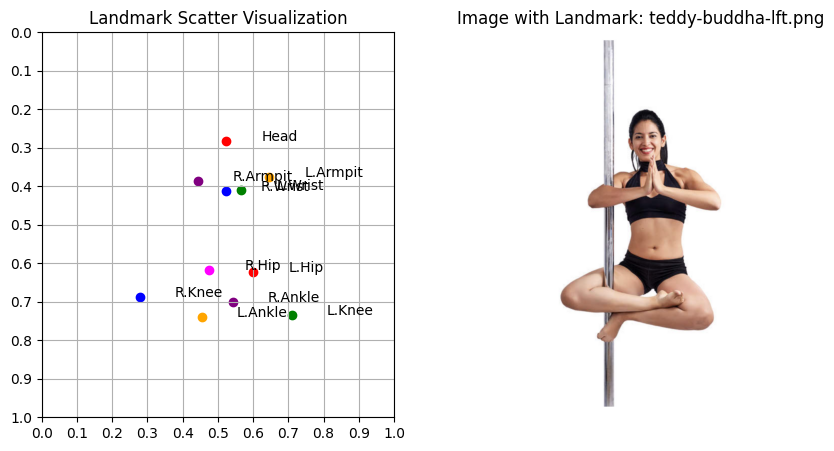

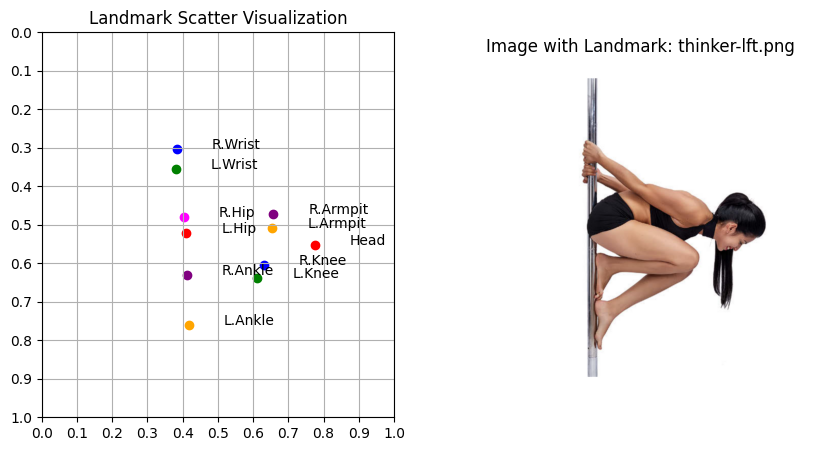

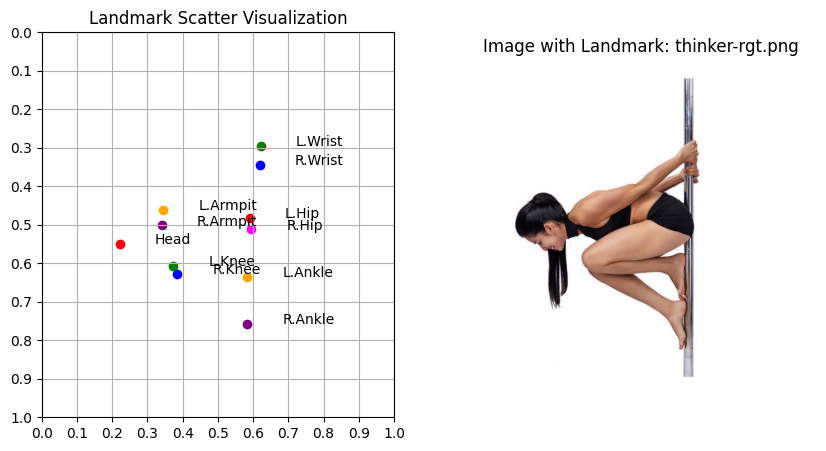

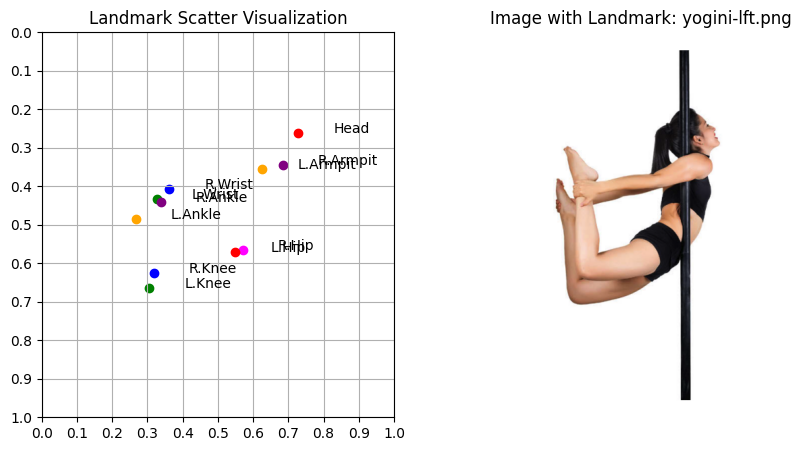

In [46]:
source_image_dir = 'data/internal/tricks/'
visualize_pose_dimension_by_keyword(source_image_dir, results.data, 'pos_legs','crossed')